# DeepQuote
## Div Dasani
Employing an LSTM Recurrent Neural Network and a [dataset of quotes](https://www.kaggle.com/coolcoder22/quotes-dataset) to generate original quotes! 

In [27]:
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json

from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as img_disp

In [28]:
def subsequence_and_format():
    num_subsequence = ((len(text) - genlen)//seqstep) + 1
    x = np.zeros((num_subsequence, genlen, numchars))
    y = np.zeros((num_subsequence, numchars))
    for i in range(0, len(text) - genlen, seqstep):
        for j, char in enumerate(text[i: i + genlen]):
            x[i//seqstep, j, char_to_num[char]] = 1
        y[i//seqstep, char_to_num[text[i + genlen]]] = 1
        
    return x,y

In [29]:
def generate_model(use_saved):
    if use_saved:
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights("model.h5")
    else:
        model = Sequential()
        model.add(LSTM(256, input_shape=(genlen, numchars)))
        model.add(Dense(numchars))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.1))

        model.fit(x, y, batch_size=256, epochs=epochs,
                  callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.001)])

        model_json = model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        model.save_weights("model.h5")
    
    return model

In [30]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [38]:
def generate_text(length, diversity, seed=False):
    rand_ind = random.randint(0, len(text) - genlen - 1)
    if not seed:
        window = text[rand_ind: rand_ind + genlen]
    elif len(seed) < genlen:
        window = (genlen-len(seed)) * ' ' + seed.lower()
    else:
        window = seed.lower()[0:genlen]
    
    generated = window
    for i in range(length):
            x_pred = np.zeros((1, genlen, numchars))
            for i, char in enumerate(window):
                x_pred[0, i, char_to_num[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            pred_char = num_to_char[sample(preds, diversity)]

            generated += pred_char
            window = window[1:] + pred_char
            
    while generated[0] == ' ':
        generated = generated[1:]
    generated = generated.replace('  ', ' ')
    generated = generated.replace('\n', ' ')
    #generated=generated[::-1][generated[::-1].find(' ')+1:][::-1]
    generated = '\"' + generated + '\"'
    
    return generated

In [32]:
def quote_to_image(quote):
    quote += '\n-DeepQuote'
    background = 'images/' + str(random.randint(1,6)) + '.jpg'
    img = Image.open(background)
    d = ImageDraw.Draw(img)
    
    w_im, h_im = img.size
    w_t, h_t = d.textsize(quote)
    w = (w_im-w_t)//2
    h = (h_im-h_t)//2
    
    d.text((w,h), quote, fill=(255,255,255))
    img.save('deep_quote.png')

In [54]:
filename = 'QUOTE.csv'
use_saved = True
to_image = True
genlen = 15
seqstep = 10
epochs = 5
seed = 'Let it be '

In [34]:
text = open(filename, 'r').read().lower()
text = text.replace('\"', '')
charset = sorted(list(set(text)))
numchars = len(charset)

char_to_num = dict((c, x) for x, c in enumerate(charset))
num_to_char = dict((x, c) for x, c in enumerate(charset))

x,y = subsequence_and_format()
model = generate_model(use_saved)

In [67]:
quote = generate_text(85, 0.35, seed)
print(quote)
if to_image:
    quote_to_image(quote)

"let it be a man's bears and any other than the bad be the same things and a street for me be th"


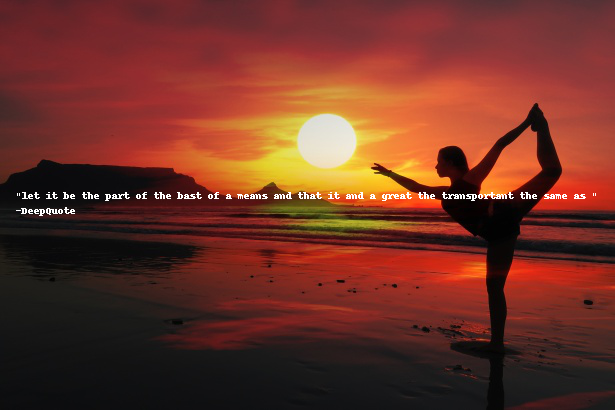

In [65]:
img_disp(filename='deep_quote.png') 